# Grid algorithm for a beta-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

In [6]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Hospital Data with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [10]:
import pymc3 as pm

with pm.Model() as model:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
    ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


Here's the graph representation of the model, showing that the observable is an array of 13 values.

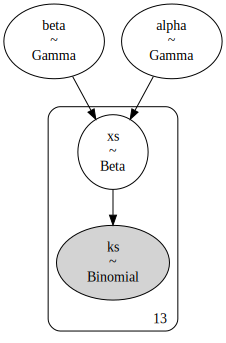

In [11]:
pm.model_to_graphviz(model)

Here are the posterior distributions of alpha and beta.

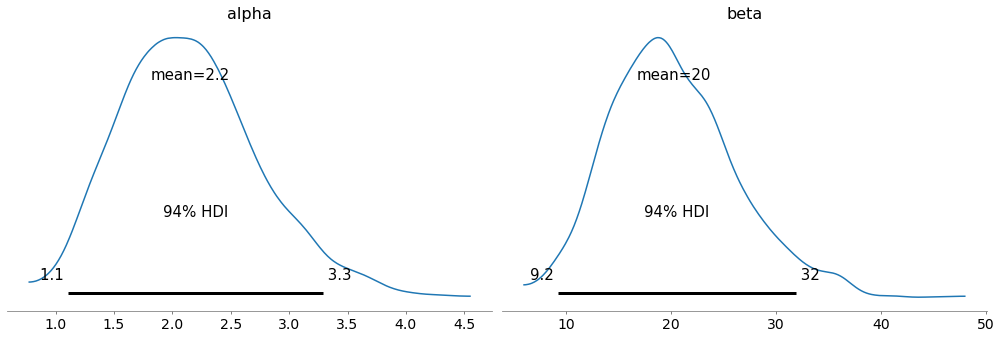

In [12]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

And we can extract the posterior distributions of the xs.

In [13]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

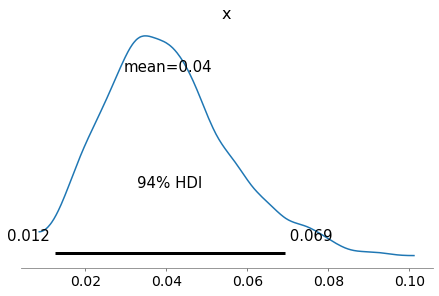

In [14]:
with model:
    az.plot_posterior(trace_xs[0])

## Just one update

In [15]:
data_n = data_ns[0]
data_k = data_ks[0]

#data_n = 250
#data_k = 140

In [16]:
with pm.Model() as model1:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    x = pm.Beta('x', alpha, beta)
    k = pm.Binomial('k', n=data_n, p=x, observed=data_k)
    pred1 = pm.sample_prior_predictive(1000)
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here's the graphical representation of the model.

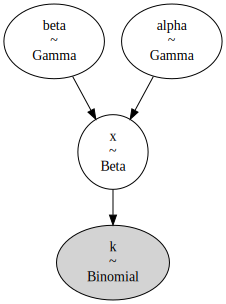

In [17]:
pm.model_to_graphviz(model1)

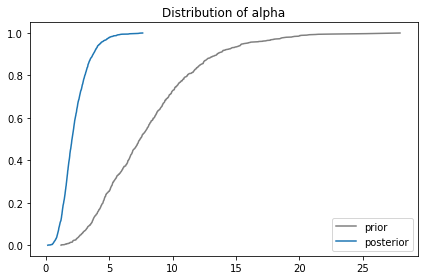

In [18]:
from empiricaldist import Cdf

Cdf.from_seq(pred1['alpha']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['alpha']).plot(label='posterior')
decorate(title='Distribution of alpha')

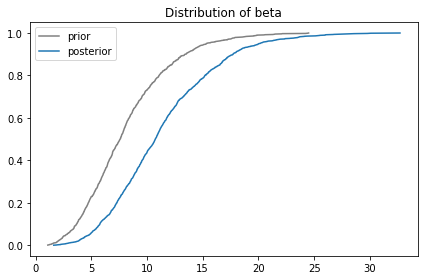

In [19]:
Cdf.from_seq(pred1['beta']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['beta']).plot(label='posterior')
decorate(title='Distribution of beta')

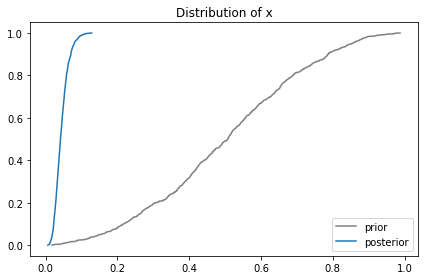

In [20]:
Cdf.from_seq(pred1['x']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['x']).plot(label='posterior')
decorate(title='Distribution of x')

## The grid priors

In [21]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

In [22]:
import numpy as np
from scipy.stats import gamma

alpha = 4
beta = 0.5

qs = np.linspace(0.1, 25, 100)
ps = gamma(alpha, scale=1/beta).pdf(qs)
prior_alpha = make_pmf(ps, qs, 'alpha')

In [23]:
def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

7.970910788849202 8.112236783300132


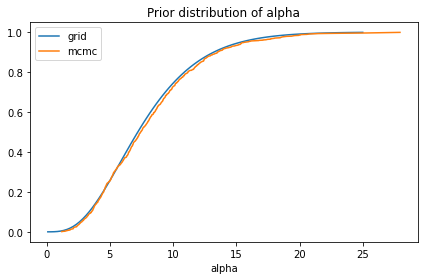

In [24]:
compare_cdf(prior_alpha, pred1['alpha'])
decorate(title='Prior distribution of alpha')

In [53]:
qs = np.linspace(0.1, 50, 90)
ps = gamma(alpha, scale=1/beta).pdf(qs)
prior_beta = make_pmf(ps, qs, 'beta')

7.999987656838361 8.120003023933446


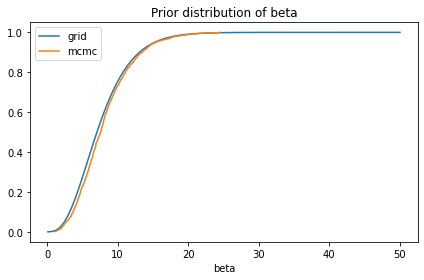

In [54]:
compare_cdf(prior_beta, pred1['beta'])
decorate(title='Prior distribution of beta')

## The joint distribution of hyperparameters

In [55]:
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

In [56]:
hyper = make_hyper(prior_alpha, prior_beta)
hyper.shape

(100, 90)

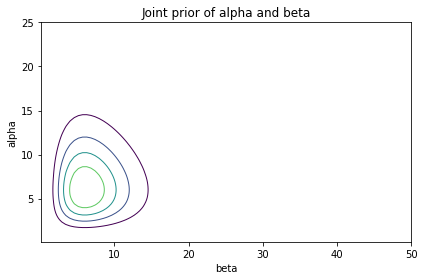

In [57]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(hyper, index=prior_alpha.index, columns=prior_beta.index))
decorate(title="Joint prior of alpha and beta")

In [58]:
hyper

array([[1.38658081e-11, 3.02105267e-09, 1.44200280e-08, ...,
        4.14145747e-14, 3.23790668e-14, 2.53050893e-14],
       [5.31081914e-10, 1.15710994e-07, 5.52309396e-07, ...,
        1.58624232e-12, 1.24016838e-12, 9.69224093e-13],
       [2.36445445e-09, 5.15162289e-07, 2.45896231e-06, ...,
        7.06218310e-12, 5.52141124e-12, 4.31512759e-12],
       ...,
       [1.02694603e-09, 2.23748810e-07, 1.06799333e-06, ...,
        3.06729569e-12, 2.39809711e-12, 1.87417574e-12],
       [9.33771369e-10, 2.03448113e-07, 9.71094452e-07, ...,
        2.78900039e-12, 2.18051810e-12, 1.70413204e-12],
       [8.48787375e-10, 1.84931981e-07, 8.82713626e-07, ...,
        2.53516910e-12, 1.98206574e-12, 1.54903632e-12]])

## Joint prior of alpha, beta, and x

In [59]:
from scipy.stats import beta as betadist

def make_prior(hyper, prior_alpha, prior_beta, xs):
    
    A, B, X = np.meshgrid(prior_alpha.qs, prior_beta.qs, xs, indexing='ij')
    ps = betadist.pdf(X, A, B)

    # compute sums along the x axis
    totals = ps.sum(axis=2)
    
    # multiply by the prior of the hyperparameters
    # and divide by the totals
    nc = hyper / totals

    # reshape the normalizing constants so we can multiply
    # along the x axis
    shape = nc.shape + (1,)
    prior = ps * nc.reshape(shape)

    return prior

In [60]:
xs = np.linspace(0.01, 0.99, 80)
%time prior = make_prior(hyper, prior_alpha, prior_beta, xs)
prior.sum()

CPU times: user 355 ms, sys: 202 µs, total: 355 ms
Wall time: 354 ms


0.9999999999999999

The following function computes the marginal distributions.

In [61]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

And let's confirm that the marginal distributions are what they are supposed to be.

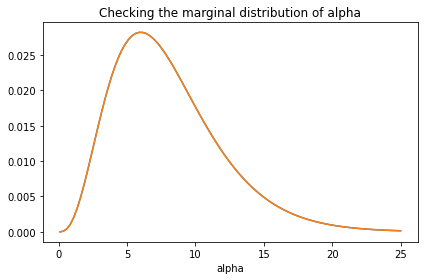

In [62]:
prior_alpha.plot()
marginal_alpha = Pmf(marginal(prior, 0), prior_alpha.qs)
marginal_alpha.plot()
decorate(title='Checking the marginal distribution of alpha')

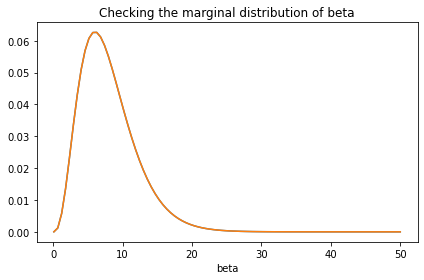

In [63]:
prior_beta.plot()
marginal_beta = Pmf(marginal(prior, 1), prior_beta.qs)
marginal_beta.plot()
decorate(title='Checking the marginal distribution of beta')

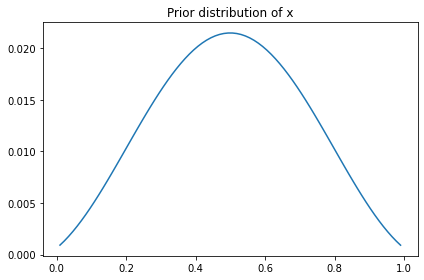

In [64]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()
decorate(title='Prior distribution of x')

0.4995803824728995 0.5022874485270423


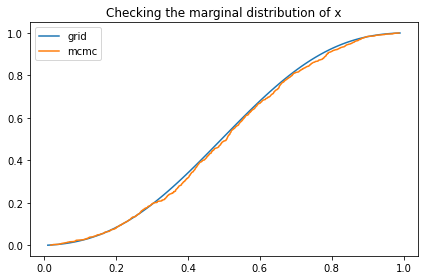

In [65]:
marginal_x = Pmf(marginal(prior, 2), xs)
compare_cdf(marginal_x, pred1['x'])
decorate(title='Checking the marginal distribution of x')

## The Update

In [66]:
from scipy.stats import binom

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(80,)

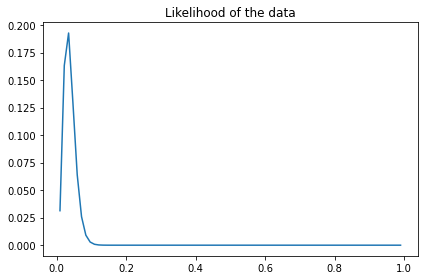

In [67]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

In [68]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [69]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 4.9 ms, sys: 311 µs, total: 5.21 ms
Wall time: 3.43 ms


2.2607011200781164 2.288253927730324


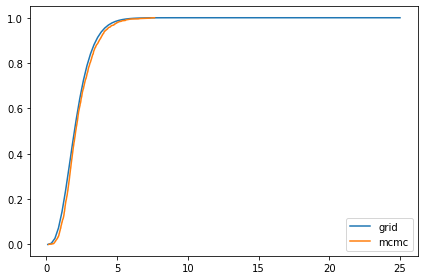

In [70]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace1['alpha'])

11.21828639633334 11.364572434569213


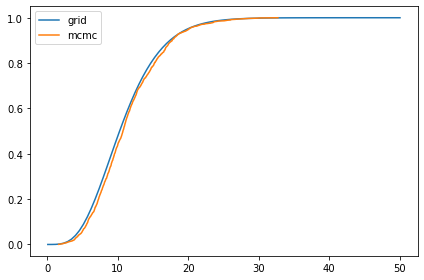

In [71]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace1['beta'])

0.043880166616675244 0.0443656954433486


(0.043880166616675244, 0.0443656954433486)

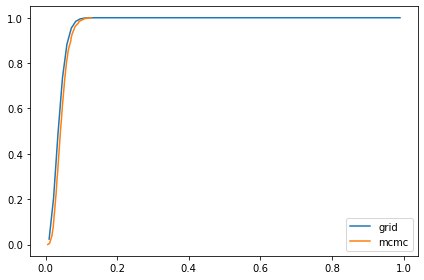

In [72]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace1['x'])
marginal_x.mean(), trace1['x'].mean()

## Multiple updates

In [73]:
hyper = make_hyper(prior_alpha, prior_beta)
hyper.shape

(100, 90)

In [74]:
xs = np.linspace(0.01, 0.99, 80)
prior = make_prior(hyper, prior_alpha, prior_beta, xs)
prior.shape

(100, 90, 80)

In [75]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [76]:
def multiple_updates(prior, ns, ks, xs):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper, prior_alpha, prior_beta, xs)
    return prior, posterior

In [77]:
%time prior, posterior = multiple_updates(prior, data_ns, data_ks, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 4.49 s, sys: 24.3 ms, total: 4.51 s
Wall time: 4.5 s


2.097512983074644 2.1561074009239913


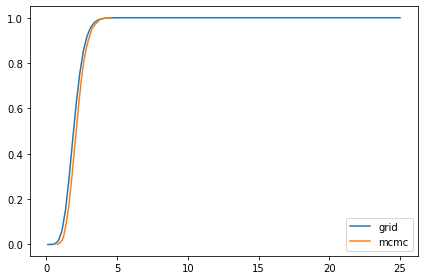

In [78]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace['alpha'])

19.852137484809283 20.24234559079447


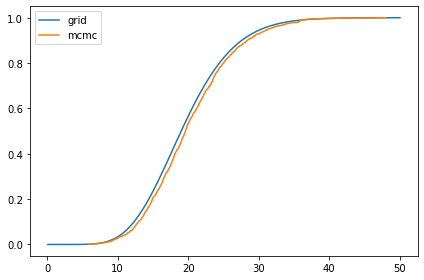

In [79]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace['beta'])

0.09707212033155088 0.09764915514429169


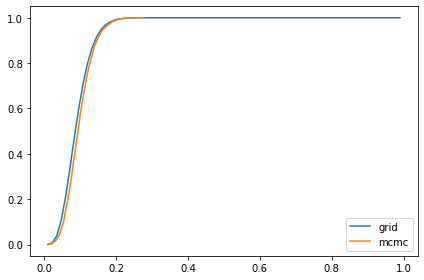

In [81]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
compare_cdf(marginal_x, trace_xs[-1])

## One at a time

In [82]:
prior.shape, prior.sum()

((100, 90, 80), 0.9999999999999998)

In [83]:
likelihood = np.empty((len(df), len(xs)))

for i, row in df.iterrows():
    n = row['Cases']
    k = row['Deaths']
    likelihood[i] = binom.pmf(k, n, xs)

In [84]:
prod = likelihood.prod(axis=0)
prod.shape

(80,)

In [85]:
i = 3
all_but_one = prod / likelihood[i]

In [86]:
prior

array([[[9.38780283e-018, 4.59389461e-018, 3.12571309e-018, ...,
         3.12571309e-018, 4.59389461e-018, 9.38780283e-018],
        [1.37909033e-012, 6.70099646e-013, 4.52686839e-013, ...,
         7.02743950e-014, 8.06749577e-014, 1.04879747e-013],
        [8.57078371e-011, 4.13520286e-011, 2.77361192e-011, ...,
         6.68411926e-013, 5.99370736e-013, 4.95699378e-013],
        ...,
        [2.65764792e-023, 7.03056732e-024, 2.56580082e-024, ...,
         1.06208054e-094, 7.22993692e-104, 1.20255070e-120],
        [1.58440122e-023, 4.16186224e-024, 1.50803238e-024, ...,
         9.69046069e-096, 5.15265655e-105, 5.45217815e-122],
        [9.44684749e-024, 2.46399059e-024, 8.86446249e-025, ...,
         8.84271061e-097, 3.67266992e-106, 2.47224037e-123]],

       [[8.23758577e-019, 4.93781016e-019, 3.75346411e-019, ...,
         8.65655873e-019, 1.27635695e-018, 2.61657048e-018],
        [1.54808188e-012, 9.21420723e-013, 6.95418517e-013, ...,
         2.48976587e-013, 2.86744496e-

In [87]:
hyper_i = get_hyper(prior * all_but_one)
hyper_i.sum()

7.97878210024418e-16

In [88]:
prior_i = make_prior(hyper_i, prior_alpha, prior_beta, xs)

In [89]:
data = df.loc[i, 'Cases'], df.loc[i, 'Deaths']
data

(84, 7)

In [90]:
posterior_i = update(prior_i, data)

In [91]:
marginal_alpha = Pmf(marginal(posterior_i, 0), prior_alpha.qs)
marginal_beta = Pmf(marginal(posterior_i, 1), prior_beta.qs)
marginal_x = Pmf(marginal(posterior_i, 2), prior_x.qs)

2.2118989111174576 2.1561074009239913


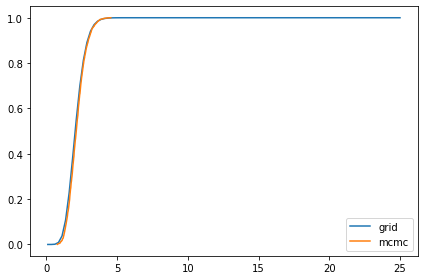

In [92]:
compare_cdf(marginal_alpha, trace['alpha'])

21.347689380761715 20.24234559079447


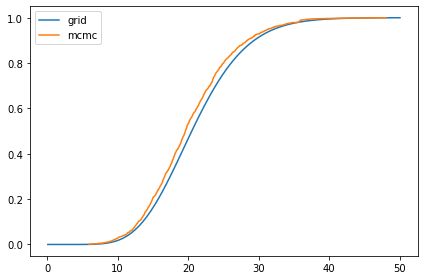

In [93]:
compare_cdf(marginal_beta, trace['beta'])

0.08568040914334583 0.0860931732016485


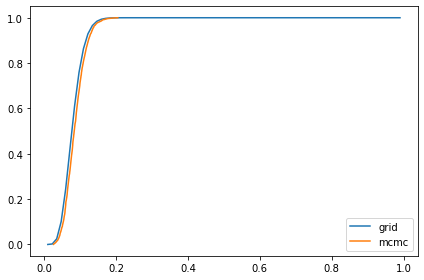

In [94]:
compare_cdf(marginal_x, trace_xs[i])